In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("cleaned_Online_Retail.csv")
data.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpend,Year,Month,Day_of_Week,Is_weekend
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,Wednesday,0
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,Wednesday,0
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,Wednesday,0
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,Wednesday,0
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,Wednesday,0


In [3]:
data.shape

(387349, 14)

In [4]:
data = data.drop(columns=['Unnamed: 0'])
data['Description'] = data['Description'].str.strip()
data['StockCode'] = data['StockCode'].str.strip()
data = data[data['StockCode'].str.contains(r'\d', na=False)]
UK_data = data[data['Country']== 'United Kingdom']

In [5]:
UK_customer_data = data.groupby('CustomerID').agg({
    'InvoiceNo': pd.Series.nunique,
    'TotalSpend': 'sum'
})

UK_customer_data = UK_customer_data.reset_index()
UK_customer_data.head()

,CustomerID,InvoiceNo,TotalSpend
0,12346.0,2,0.00
1,12413.0,4,676.15
2,12426.0,1,510.73
3,12427.0,5,582.37
4,12437.0,19,4392.66


The zero total spend, which results from product returns, suggests a need for further investigation into these specific products. This exploration might reveal whether quality issues or other factors are driving these returns, allowing for targeted improvements in product offerings or customer satisfaction initiatives.

In [6]:
# I use description because a same description can have more than 1 stockcode. 
UK_return_products = UK_data[UK_data['Quantity'] < 0]
print (UK_return_products['Description'].nunique(), 'unique products has been returned')

1771 unique products has been returned


In [7]:
### Remove the return products
# We groupby the Unitprice because a product that have different price
UK_product_no_return = UK_data[UK_data['Quantity']>0]
UK_product_no_return = UK_product_no_return.groupby(['Description', 'UnitPrice']).agg({
    'Quantity' : 'sum',
    'TotalSpend' : 'sum',
}).rename(columns={'TotalSpend': 'Total_Revenue', 'Quantity': 'Unit_Sold'})

UK_product_no_return = UK_product_no_return.reset_index()

In [8]:
UK_product_no_return.head()

,Description,UnitPrice,Unit_Sold,Total_Revenue
0,10 COLOUR SPACEBOY PEN,0.72,144,103.68
1,10 COLOUR SPACEBOY PEN,0.85,4162,3537.70
2,10 COLOUR SPACEBOY PEN,1.63,17,27.71
3,12 COLOURED PARTY BALLOONS,0.65,1787,1161.55
4,12 COLOURED PARTY BALLOONS,1.25,3,3.75


In [9]:
# Change to positive
UK_return_products['Quantity'] = UK_return_products['Quantity'] * -1
UK_return_products['TotalSpend'] = UK_return_products['TotalSpend'] * -1

UK_return_products_grouped = UK_return_products.groupby(['Description', 'UnitPrice']).agg({
    'Quantity' : 'sum',
    'TotalSpend' : 'sum',
}).rename(columns={'Quantity': 'TotalReturned', 'TotalSpend': 'Total$Returned'})

/var/folders/x_/08j42z3j22377xv4cbjvxw880000gn/T/ipykernel_39524/2086350037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UK_return_products['Quantity'] = UK_return_products['Quantity'] * -1
/var/folders/x_/08j42z3j22377xv4cbjvxw880000gn/T/ipykernel_39524/2086350037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UK_return_products['TotalSpend'] = UK_return_products['TotalSpend'] * -1


In [10]:
UK_return_products_grouped = UK_return_products_grouped.reset_index()
UK_return_products_grouped

,Description,UnitPrice,TotalReturned,Total$Returned
0,10 COLOUR SPACEBOY PEN,0.85,165,140.25
1,12 COLOURED PARTY BALLOONS,0.65,20,13.00
2,12 EGG HOUSE PAINTED WOOD,12.75,1,12.75
3,12 IVORY ROSE PEG PLACE SETTINGS,1.25,1,1.25
4,12 PENCIL SMALL TUBE WOODLAND,0.65,4,2.60
...,...,...,...,...
2368,ZINC T-LIGHT HOLDER STAR LARGE,0.95,11,10.45
2369,ZINC T-LIGHT HOLDER STARS SMALL,0.83,44,36.52
2370,ZINC TOP 2 DOOR WOODEN SHELF,14.95,4,59.80
2371,ZINC TOP 2 DOOR WOODEN SHELF,16.95,1,16.95


In [11]:
# UK_return_products_name = UK_return_products[['StockCode', 'Description']]
# UK_return_products_name = UK_return_products_name.drop_duplicates(subset=['StockCode'], keep='first')

# Merge with product description
UK_return_rate = pd.merge(UK_return_products_grouped, UK_product_no_return, on=('Description', 'UnitPrice'), how='left')

UK_return_rate.head(10)

,Description,UnitPrice,TotalReturned,Total$Returned,Unit_Sold,Total_Revenue
0,10 COLOUR SPACEBOY PEN,0.85,165,140.25,4162.0,3537.70
1,12 COLOURED PARTY BALLOONS,0.65,20,13.00,1787.0,1161.55
2,12 EGG HOUSE PAINTED WOOD,12.75,1,12.75,75.0,956.25
3,12 IVORY ROSE PEG PLACE SETTINGS,1.25,1,1.25,708.0,885.00
4,12 PENCIL SMALL TUBE WOODLAND,0.65,4,2.60,2410.0,1566.50
5,12 PENCILS SMALL TUBE RED RETROSPOT,0.65,120,78.00,4577.0,2975.05
6,12 PENCILS SMALL TUBE SKULL,0.65,566,367.90,4607.0,2994.55
7,12 PENCILS TALL TUBE POSY,0.29,24,6.96,3152.0,914.08
8,12 PENCILS TALL TUBE RED RETROSPOT,0.85,3,2.55,2084.0,1771.40
9,12 PENCILS TALL TUBE SKULLS,0.85,4,3.40,1875.0,1593.75


In [12]:
# Create Net_Revenue and Return_Rate
UK_return_rate['Net_Revenue'] = UK_return_rate['Total_Revenue'] - UK_return_rate['Total$Returned']
UK_return_rate['Return_Rate'] = (UK_return_rate['TotalReturned'] / UK_return_rate['Unit_Sold']) * 100

In [13]:
# Check missing value
UK_return_rate.isnull().sum()

Description        0
UnitPrice          0
TotalReturned      0
Total$Returned     0
Unit_Sold         77
Total_Revenue     77
Net_Revenue       77
Return_Rate       77
dtype: int64

In [14]:
UK_return_rate.shape

(2373, 8)

In [15]:
UK_return_rate[UK_return_rate['Unit_Sold'].isnull()]

,Description,UnitPrice,TotalReturned,Total$Returned,Unit_Sold,Total_Revenue,Net_Revenue,Return_Rate
18,3 DRAWER ANTIQUE WHITE WOOD CABINET,7.95,2,15.90,NaN,NaN,NaN,NaN
89,ANTIQUE LILY FAIRY LIGHTS,4.95,3,14.85,NaN,NaN,NaN,NaN
118,ASSORTED TUTTI FRUTTI ROUND BOX,1.65,24,39.60,NaN,NaN,NaN,NaN
140,BAKING SET 9 PIECE RETROSPOT,0.70,6,4.20,NaN,NaN,NaN,NaN
190,BLACK PHOTO ALBUM,5.55,1,5.55,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2310,WOODEN CROQUET GARDEN SET,10.95,1,10.95,NaN,NaN,NaN,NaN
2326,WOODEN SKITTLES GARDEN SET,3.25,4,13.00,NaN,NaN,NaN,NaN
2337,WOOLLY HAT SOCK GLOVE ADVENT STRING,2.95,1,2.95,NaN,NaN,NaN,NaN
2338,WORLD WAR 2 GLIDERS ASSTD DESIGNS,0.11,96,10.56,NaN,NaN,NaN,NaN


In [16]:
UK_data[UK_data['Description']=='ANTIQUE LILY FAIRY LIGHTS']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpend,Year,Month,Day_of_Week,Is_weekend
27512,C540246,85042,ANTIQUE LILY FAIRY LIGHTS,-2,2011-01-05 15:43:00,4.95,13081.0,United Kingdom,-9.90,2011,1,Wednesday,0
28958,C540393,85042,ANTIQUE LILY FAIRY LIGHTS,-1,2011-01-06 18:08:00,4.95,17428.0,United Kingdom,-4.95,2011,1,Thursday,0


We have missing value due to the limit data by date.

In [17]:
# Remove NaN
UK_return_rate = UK_return_rate.dropna(subset='Unit_Sold')

In [18]:
# There are data that is over 100% return rate, which means return product is higher than sold product. 
UK_return_rate[UK_return_rate['Return_Rate']>100]

,Description,UnitPrice,TotalReturned,Total$Returned,Unit_Sold,Total_Revenue,Net_Revenue,Return_Rate
204,BLUE CHARLIE+LOLA PERSONAL DOORSIGN,2.95,152,448.40,22.0,64.90,-383.50,690.909091
224,BLUE PADDED SOFT MOBILE,4.25,4,17.00,1.0,4.25,-12.75,400.000000
329,CARDHOLDER GINGHAM CHRISTMAS TREE,2.55,50,127.50,22.0,56.10,-71.40,227.272727
530,CURIOUS IMAGES NOTEBOOK SET,4.25,12,51.00,6.0,25.50,-25.50,200.000000
536,DAIRY MAID TRADITIONAL TEAPOT,5.95,4,23.80,2.0,11.90,-11.90,200.000000
674,ENGLISH ROSE SPIRIT LEVEL,1.25,4,5.00,1.0,1.25,-3.75,400.000000
966,HEART WOODEN CHRISTMAS DECORATION,0.72,192,138.24,24.0,17.28,-120.96,800.000000
1493,PINK CHERRY LIGHTS,6.75,8,54.00,4.0,27.00,-27.00,200.000000
1530,PINK SMALL GLASS CAKE STAND,1.95,27,52.65,24.0,46.80,-5.85,112.500000
1655,RED RETROSPOT PUDDING BOWL,3.75,50,187.50,32.0,120.00,-67.50,156.250000


In [19]:
UK_data[UK_data['Description']=='BLUE PADDED SOFT MOBILE']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpend,Year,Month,Day_of_Week,Is_weekend
103333,550033,20703,BLUE PADDED SOFT MOBILE,1,2011-04-14 11:45:00,4.25,15005.0,United Kingdom,4.25,2011,4,Thursday,0
112991,C551285,20703,BLUE PADDED SOFT MOBILE,-1,2011-04-27 14:07:00,4.25,15005.0,United Kingdom,-4.25,2011,4,Wednesday,0
143577,C555398,20703,BLUE PADDED SOFT MOBILE,-3,2011-06-02 17:30:00,4.25,17375.0,United Kingdom,-12.75,2011,6,Thursday,0


#### Reasons where the return rate might appear to exceed 100% of sales within a given time frame.:
- Cross-Year Returns: Products sold towards the end of one fiscal year and returned in the next, especially when not accounting for boundary periods in the data analysis.

- Data Entry Errors: Mistakes in logging sales and returns data can lead to discrepancies where returns might be over-reported relative to sales.

- Seasonal Returns: Products bought for specific occasions (e.g., holidays or events) that are returned soon after, particularly if these coincide with the end of the data collection period.

- Multiple Returns of the Same Item: Items that are returned, resold, and potentially returned again within the same analysis period can inflate return statistics.

In [20]:
# In this case, I will drop the products with over 100 return rate.
UK_return_rate_cleaned = UK_return_rate[UK_return_rate['Return_Rate']<100]
UK_return_rate_cleaned.shape

(2252, 8)

In [21]:
UK_return_rate_cleaned.describe()

,UnitPrice,TotalReturned,Total$Returned,Unit_Sold,Total_Revenue,Net_Revenue,Return_Rate
count,2252.000000,2252.000000,2252.000000,2252.000000,2252.000000,2252.000000,2252.000000
mean,3.878086,69.908526,113.224232,1177.169627,2193.270178,2080.045946,6.218053
std,10.020015,1574.355004,1659.232247,2390.093016,3856.532897,3363.185902,11.869856
min,0.060000,1.000000,0.120000,2.000000,4.920000,3.480000,0.012340
25%,1.250000,3.000000,7.500000,185.750000,438.925000,401.925000,0.746866
50%,2.080000,10.000000,20.650000,532.500000,1118.355000,1080.600000,2.022014
75%,4.250000,26.000000,61.212500,1397.250000,2640.450000,2521.462500,5.837712
max,295.000000,74464.000000,77442.560000,75511.000000,78531.440000,65272.950000,98.613447


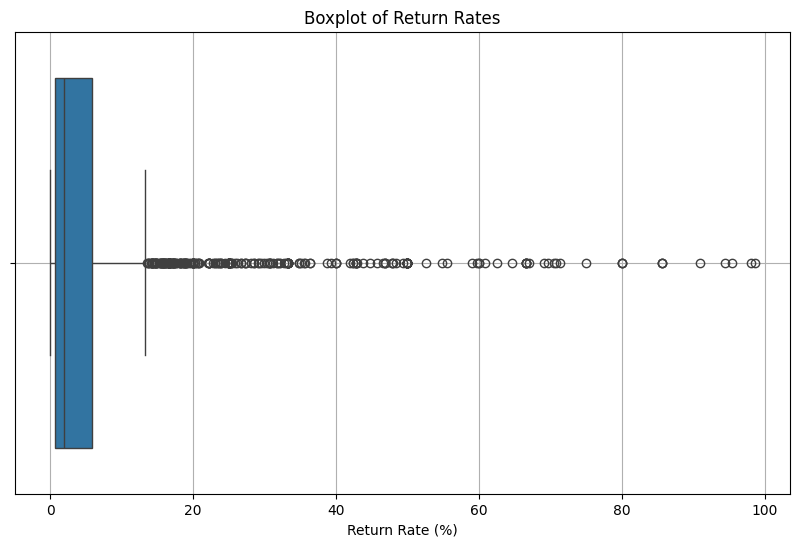

In [22]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=UK_return_rate_cleaned['Return_Rate'])
plt.title('Boxplot of Return Rates')
plt.xlabel('Return Rate (%)')
plt.grid(True)
plt.show()

In [23]:
# Find the products that are above 75% percentile return rate. So the companies should explore on these products.
above_75_pct_rtn_rate = UK_return_rate_cleaned[UK_return_rate_cleaned['Return_Rate'] > UK_return_rate_cleaned['Return_Rate'].quantile(0.75)]
above_75_pct_rtn_rate['Description']

6               12 PENCILS SMALL TUBE SKULL
19      3 DRAWER ANTIQUE WHITE WOOD CABINET
22          3 GARDENIA MORRIS BOXED CANDLES
26         3 HOOK PHOTO SHELF ANTIQUE WHITE
30              3 ROSE MORRIS BOXED CANDLES
                       ...                 
2336             WOODLAND STORAGE BOX SMALL
2343            WRAP CHRISTMAS SCREEN PRINT
2353      YELLOW EASTER EGG HUNT START POST
2355                YELLOW/BLUE RETRO RADIO
2371          ZINC TOP  2 DOOR WOODEN SHELF
Name: Description, Length: 563, dtype: object

In [24]:
# Find the products that are outlier. The companies should focus on these product immediately. 
Q3 = UK_return_rate_cleaned['Return_Rate'].quantile(0.75)
IQR = UK_return_rate_cleaned['Return_Rate'].quantile(0.75) - UK_return_rate_cleaned['Return_Rate'].quantile(0.25)
outlier_threshold = Q3 + 1.5 * IQR
outliers_above_75 = UK_return_rate_cleaned[UK_return_rate_cleaned['Return_Rate'] > outlier_threshold]
outlier_above_75 = outliers_above_75['Description']
outlier_above_75

26        3 HOOK PHOTO SHELF ANTIQUE WHITE
30             3 ROSE MORRIS BOXED CANDLES
33           3 TIER CAKE TIN RED AND CREAM
60            ADVENT CALENDAR GINGHAM SACK
76                  ALPHABET STENCIL CRAFT
                       ...                
2324           WOODEN SCHOOL COLOURING SET
2330    WOODEN STAR CHRISTMAS SCANDINAVIAN
2331    WOODEN TREE CHRISTMAS SCANDINAVIAN
2335            WOODLAND STORAGE BOX LARGE
2336            WOODLAND STORAGE BOX SMALL
Name: Description, Length: 253, dtype: object

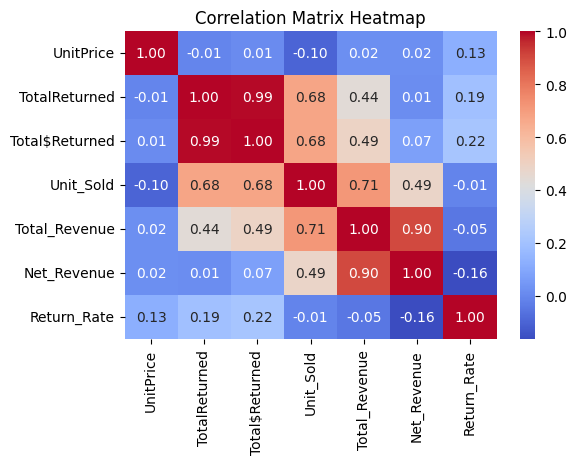

In [25]:
numeric_data = UK_return_rate_cleaned.select_dtypes(include=['number'])
UK_return_rate_corr = numeric_data.corr()

plt.figure(figsize=(6, 4))  
sns.heatmap(UK_return_rate_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

UnitPrice and Return_Rate: The correlation coefficient of 0.13 suggests a weak positive correlation, meaning higher-priced items might slightly tend to have higher return rates, though the relationship is not strong.

Return_Rate and other metrics: Return rate has relatively low correlation with most of the sales figures like Unit_Sold (0.22), suggesting that the rate of return does not strongly depend on the volume of sales.

_____


### Product Performance Analysis

In [26]:
top_sales = UK_return_rate_cleaned.nlargest(10, 'Unit_Sold')
bottom_sales = UK_return_rate_cleaned.nsmallest(10, 'Unit_Sold')
top_returns = UK_return_rate_cleaned.nlargest(10, 'Return_Rate')
bottom_returns = UK_return_rate_cleaned.nsmallest(10, 'Return_Rate')

In [27]:
print("Top Performers by Sales Volume:\n", top_sales[['Description', 'Unit_Sold', 'UnitPrice']])

Top Performers by Sales Volume:
                              Description  Unit_Sold  UnitPrice
1263      MEDIUM CERAMIC TOP STORAGE JAR    75511.0       1.04
2340   WORLD WAR 2 GLIDERS ASSTD DESIGNS    23159.0       0.29
2339   WORLD WAR 2 GLIDERS ASSTD DESIGNS    23040.0       0.21
1559                      POPCORN HOLDER    21940.0       0.72
103        ASSORTED COLOUR BIRD ORNAMENT    20591.0       1.69
2257  WHITE HANGING HEART T-LIGHT HOLDER    18622.0       2.55
1099             JUMBO BAG RED RETROSPOT    17436.0       1.79
1996                SMALL POPCORN HOLDER    12496.0       0.72
1400     PACK OF 72 RETROSPOT CAKE CASES    12330.0       0.55
192             BLACK RECORD COVER FRAME    10108.0       3.39


Pricing Strategy: The data indicates that lower-priced items tend to have higher sales volumes. Consider pricing strategies that leverage volume sales for lower-priced items while maintaining a premium on unique or niche products.

In [28]:
print("\nBottom Performers by Sales Volume:\n", bottom_sales[['Description', 'Unit_Sold', 'UnitPrice']])


Bottom Performers by Sales Volume:
                               Description  Unit_Sold  UnitPrice
467         CLASSIC DIAMANTE NECKLACE JET        2.0       7.50
1498                   PINK DOG CANNISTER        3.0       5.95
1778   RUSTIC WOODEN CABINET, GLASS DOORS        3.0      24.95
2251  WHITE BEADED GARLAND STRING 20LIGHT        3.0       6.35
197           BLACK TEA,COFFEE,SUGAR JARS        4.0       6.35
307   CAKE STAND VICTORIAN FILIGREE LARGE        4.0       8.50
1055    JET BLACK LAS VEGAS NECKLACE 45CM        4.0       5.95
2199     VINTAGE KEEPSAKE BOX PINK FLOWER        4.0       6.35
873        GRASS HOPPER WOODEN WALL CLOCK        5.0       5.95
2212          VINTAGE RED KITCHEN CABINET        5.0     295.00


In [29]:
print("\nHighest Return Rates:\n", top_returns[['Description', 'Return_Rate', 'UnitPrice']])



Highest Return Rates:
                             Description  Return_Rate  UnitPrice
1263     MEDIUM CERAMIC TOP STORAGE JAR    98.613447       1.04
1359             OFFICE MUG WARMER PINK    98.039216       2.55
818         GIN + TONIC DIET METAL SIGN    95.467557       1.85
395          CHILDRENS CUTLERY SPACEBOY    94.444444       3.75
239             BLUE ROSE FABRIC MIRROR    90.909091       1.06
300           CABIN BAG VINTAGE PAISLEY    85.714286      24.95
1504    PINK FOXGLOVE ARTIIFCIAL FLOWER    85.714286       2.55
2264   WHITE ROCKING HORSE HAND PAINTED    85.714286       1.04
155    BEADED CHANDELIER T-LIGHT HOLDER    80.000000       1.00
737   FLOWERS CHANDELIER T-LIGHT HOLDER    80.000000       1.00


In [30]:
print("\nLowest Return Rates:\n", bottom_returns[['Description', 'Return_Rate', 'UnitPrice']])


Lowest Return Rates:
                               Description  Return_Rate  UnitPrice
2329   WOODEN STAR CHRISTMAS SCANDINAVIAN     0.012340       0.29
1996                 SMALL POPCORN HOLDER     0.016005       0.72
409                         CHILLI LIGHTS     0.021683       4.95
2118     TRAVEL CARD WALLET I LOVE LONDON     0.029533       0.42
192              BLACK RECORD COVER FRAME     0.029679       3.39
2112           TRADITIONAL MODELLING CLAY     0.030230       1.06
1764  ROTATING SILVER ANGELS T-LIGHT HLDR     0.032927       2.55
1214               LUNCH BAG APPLE DESIGN     0.034247       1.45
499             COOK WITH WINE METAL SIGN     0.036550       1.85
909                HAND WARMER OWL DESIGN     0.040064       1.85


In [31]:
UK_return_rate.head()

,Description,UnitPrice,TotalReturned,Total$Returned,Unit_Sold,Total_Revenue,Net_Revenue,Return_Rate
0,10 COLOUR SPACEBOY PEN,0.85,165,140.25,4162.0,3537.70,3397.45,3.964440
1,12 COLOURED PARTY BALLOONS,0.65,20,13.00,1787.0,1161.55,1148.55,1.119194
2,12 EGG HOUSE PAINTED WOOD,12.75,1,12.75,75.0,956.25,943.50,1.333333
3,12 IVORY ROSE PEG PLACE SETTINGS,1.25,1,1.25,708.0,885.00,883.75,0.141243
4,12 PENCIL SMALL TUBE WOODLAND,0.65,4,2.60,2410.0,1566.50,1563.90,0.165975


In [32]:
UK_return_rate.to_csv('UK_return_rate.csv')